Implementation of a VQC for reinforcement learning on OpenAI Gym's Frozen Lake environment

Based off of https://github.com/ycchen1989/Var-QuantumCircuits-DeepRL/blob/master/Code/QML_DQN_FROZEN_LAKE.py

Implemented using Qiskit and PyTorch

In [67]:
import torch
import random
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import gym
import numpy as np

In [1]:
class ReplayMemory():

    # Initialize our replay memory
    def __init__(self, capacity):
        self.transitions = []
        self.capacity = capacity

    # Add a transition value to our memory
    def store_transition(self, transition):
        if len(self.transitions) < self.capacity:
            self.transitions.append(transition)
    
    # Sample a random batch from our memory
    def sample(self, batch_size):
        return random.sample(self.transitions, batch_size)

In [92]:
class Agent():
    
    def __init__(self, numQubits=4, depth=1):
        # Number of qubits used (# of wires)
        self.numQubits = numQubits

        # Number of times to apply the CNOT / rotation module
        self.depth = depth

        # Action-value function approximator
        self.qc = QuantumCircuit(numQubits)

        # State encoding parameters
        # thetas: parameters used to store angles to rotate in the x direction by
        # phis: parameters used to store angles to rotate in the z direction by
        self.thetas = [Parameter('theta_{}'.format(i)) for i in range(self.numQubits)]
        self.phis = [Parameter('phi_{}'.format(i)) for i in range(self.numQubits)]

        self.alpha_rotations = [Parameter('alpha_{}'.format(i)) for i in range(self.numQubits)]
        self.beta_rotations = [Parameter('beta_{}'.format(i)) for i in range(self.numQubits)]
        self.gamma_rotations = [Parameter('gamma_{}'.format(i)) for i in range(self.numQubits)]

    # State is a decimal value from 0 to 16
    # Converts this decimal value to a binary list
    def get_binary_state_encoding(self, state):
        return [int(i) for i in bin(state)[2:]]

    # Creates a parameterized state encoding circuit
    def state_preparation(self):
        
        # Initialize circuit with params
        for wire in range(self.numQubits):
            self.qc.rx(np.pi * self.thetas[wire], wire)
        
        for wire in range(self.numQubits):
            self.qc.rz(np.pi * self.phis[wire], wire)
    
    # Binds theta values and phi values to the quantum circuit
    # state: index of the state
    def bind_state_preparation_parameters(self, state):
        angles = self.get_binary_state_encoding(state)

        # Make sure the number of theta values and phi values are equal to the number of qubits in the circuit
        assert len(angles) == self.numQubits

        self.qc = self.qc.bind_parameters(dict(zip(self.thetas, angles)))
        self.qc = self.qc.bind_parameters(dict(zip(self.phis, angles)))
    
    # Creates a rotation layer
    def init_layer(self):
        # Create CNOT gates at each layer of the circuit
        for wire in range(self.numQubits - 1):
            self.qc.cx(wire, wire + 1)
        
        # Create rotations at each level of the circuit
        for wire in range(self.numQubits):
            self.qc.rx(self.alpha_rotations[wire], wire)
            self.qc.ry(self.beta_rotations[wire], wire)
            self.qc.rz(self.gamma_rotations[wire], wire)

    # Binds one layer of our parameterized circuit to parameters
    # alpha: array storing rotation values in x direction
    # beta: array storing rotation values in y direction
    # gamma: array storing rotation values in z direction
    def bind_layer(self, alphas, betas, gammas):
        # Length of alpha, beta, and gamma must be the same as the number of wires in the circuit
        assert len(alphas) == self.numQubits                     
        assert len(betas) == self.numQubits
        assert len(gammas) == self.numQubits

        self.qc = self.qc.bind_parameters(dict(zip(self.alpha_rotations, alphas)))
        self.qc = self.qc.bind_parameters(dict(zip(self.beta_rotations, betas)))
        self.qc = self.qc.bind_parameters(dict(zip(self.gamma_rotations, gammas)))
    
    # Outputs a score for each action
    # Four actions
    # If expectation value from qubit 0 is highest, then action selected is LEFT
    # If expectation value from qubit 1 is highest, then action selected is DOWN
    # If expectation value from qubit 2 is highest, then action selected is RIGHT
    # If expectation value from qubit 3 is highest, then action selected is UP
    # state: The state we're in
    # num_iterations: The number of times to use to calculate our expectation values
    def select_action(self, state, num_iterations=10):

In [ ]:
class Runner():

    def __init__(self, num_episodes, epsilon):


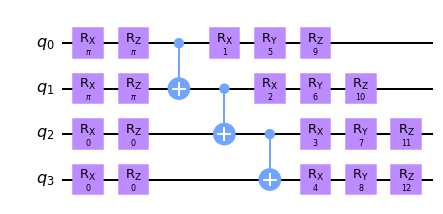

In [94]:
a = Agent()
a.state_preparation()
a.bind_state_preparation_parameters(12)
a.init_layer()
a.bind_layer([1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12])
a.qc.draw(output='mpl')

In [11]:
env = gym.make('FrozenLake-v1', is_slippery=False)